<a href="https://colab.research.google.com/github/edoardorossi1995/Tesi/blob/main/DQN_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive & Environment Setting

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  print("1")
  if gpu_info.find('failed')>=0:
    print('Not connetcted to a gpu')
  else:
    print(gpu_info)
    print("2")
  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')  
  
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
from functions.compressor import compress
from functions.compressor_param import compress_2

import random
from collections import defaultdict

import time



print("Libraries imported")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Tesi_GDrive
1
Fri May 19 13:30:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |

# Import Anagrafica e CTA

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')
CTA30_18 = [cta30_18_path]
CTA30_19 = [cta30_19_path]
CTA30_20 = [cta30_20_path]
CTA30_21 = [cta30_21_path]
CTA30_22 = [cta30_22_path]

df18= pd.read_csv(CTA30_18[0])
df19= pd.read_csv(CTA30_19[0])
df20= pd.read_csv(CTA30_20[0])
df21= pd.read_csv(CTA30_21[0])
df22= pd.read_csv(CTA30_22[0])
df = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

df['VLV_RAF_REG_00'] = df['VLV_RAF_REG_00'] / 100
df['VLV_SUR_REG_00'] = df['VLV_SUR_REG_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)
r_pw_m = df.loc[:,'PW_ATT_M_00']
r_pw_m_reshaped = np.array(r_pw_m).reshape(-1,1)
r_pw_m_scaled = scaler.fit_transform(r_pw_m_reshaped)


min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = df['VLV_RAF_REG_00'] * 0.5
a_sur_df = df['VLV_SUR_REG_00'] * 0.5 + 0.5

a_df = pd.concat([a_raf_df, a_sur_df], ignore_index=True)

pca_df = compress_2(df, 0.93)
print("df18 shape: ", df18.shape)
print("df19 shape: ", df19.shape)
[r,c] = df.shape
print("df shape: ", df.shape)
[r,n_components] = pca_df.shape
print("pca_df shape: ", pca_df.shape)

df18 shape:  (141811, 76)
df19 shape:  (523489, 76)
df shape:  (2176378, 76)
pca_df shape:  (2176378, 9)


In [3]:
df_def

,pointColName,pointName
0,AUTOMAN_SERR_CMD_00,Automatico Manuale Serrande Comando
1,AUTOMAN_VLV_CMD_00,Automatico Manuale Valvole Comando
2,AUTOMAN_M_CMD_00,Automatico Manuale Mandata Comando
3,AUTOMAN_R_CMD_00,Automatico Manuale Ripresa Comando
4,LOCREM_CMD_00,Selettore Locale Remoto Comando
...,...,...
71,VOLT_R_00,Tensione Ripresa
72,T_M_SP_00,Temperatura Aria Mandata Setpoint
73,T_R_SP_00,Temperatura Aria Ritorno Setpoint
74,T_AMB_04,Temperatura Aria Ambiente Media


# Batch Analisys & Preparation

<Axes: title={'center': 'F_M_FDBK_00'}>

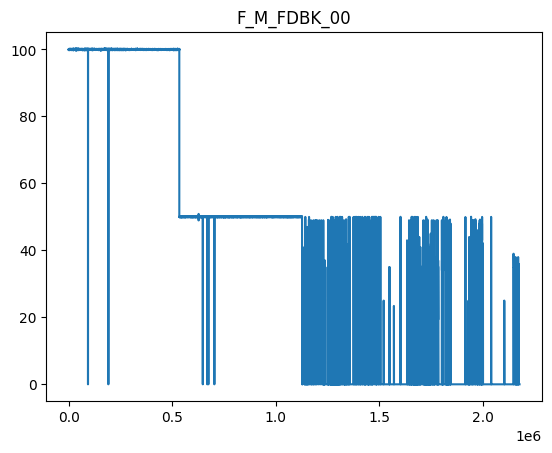

In [ ]:
df['F_M_FDBK_00'].plot(title='F_M_FDBK_00')

<Axes: title={'center': 'VLV_RAF_REG_00'}>

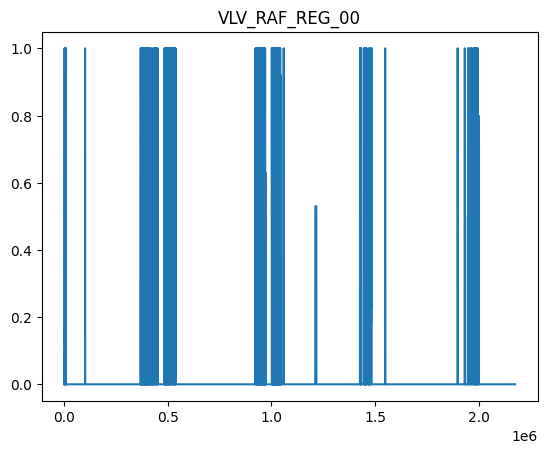

In [ ]:
df['VLV_RAF_REG_00'].plot(title='VLV_RAF_REG_00')

<Axes: title={'center': 'VLV_SUR_REG_00'}>

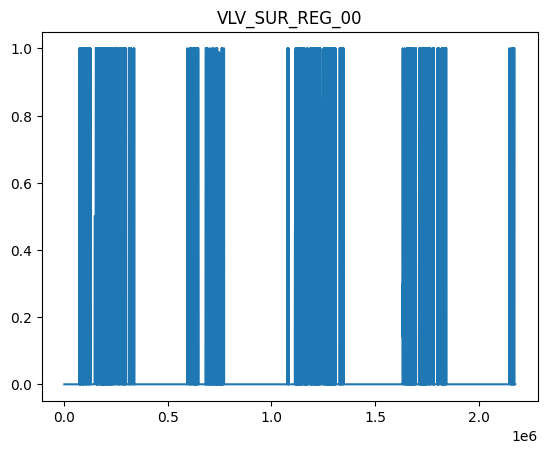

In [ ]:
df['VLV_SUR_REG_00'].plot(title='VLV_SUR_REG_00')

<Axes: title={'center': 'pw_scaled'}>

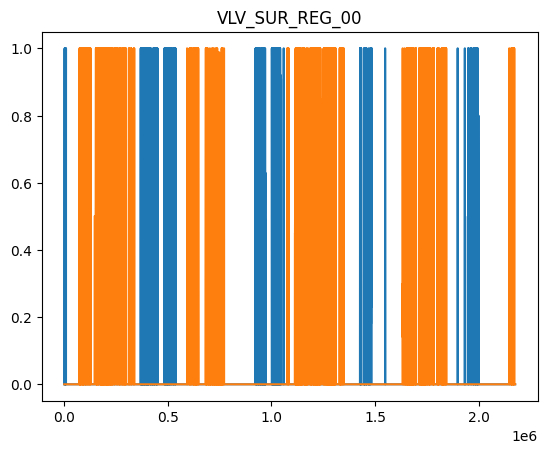

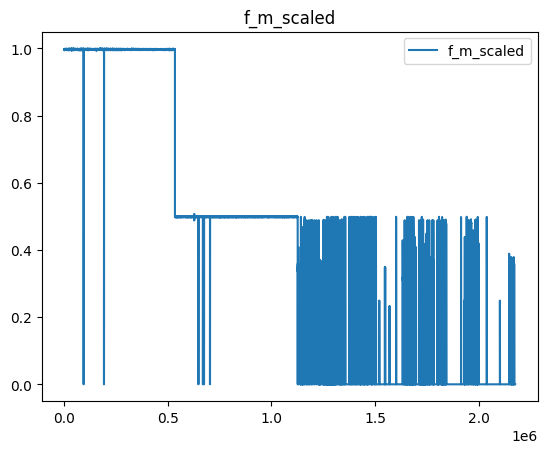

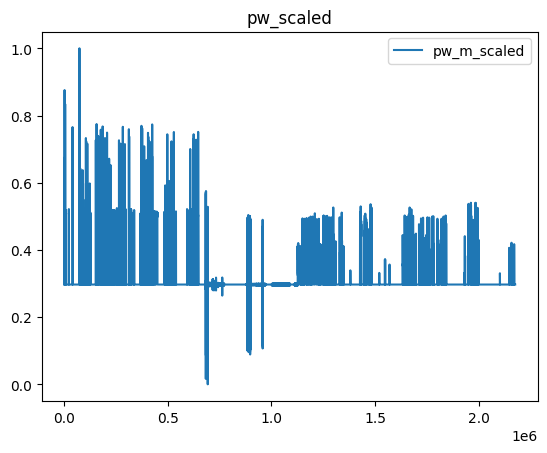

In [ ]:

df_f_m_scaled = pd.DataFrame(a_f_m_scaled, columns=["f_m_scaled"])
df['VLV_RAF_REG_00'].plot(title='VLV_RAF_REG_00')
df['VLV_SUR_REG_00'].plot(title='VLV_SUR_REG_00')
df_f_m_scaled.plot(title='f_m_scaled')
df_pw_scaled = pd.DataFrame(r_pw_m_scaled, columns=["pw_m_scaled"])
df_pw_scaled.plot(title='pw_scaled')

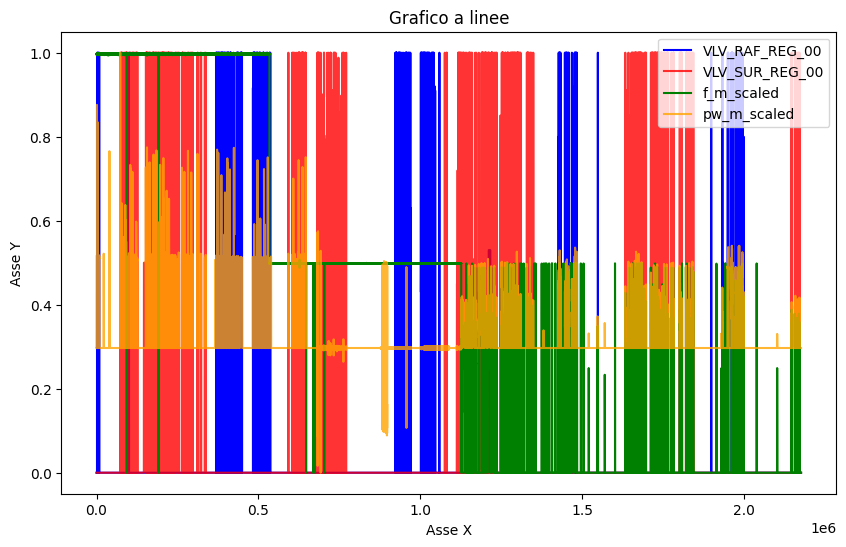

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

df['VLV_RAF_REG_00'].plot(ax=ax, color='blue', label='VLV_RAF_REG_00', alpha=1)
df['VLV_SUR_REG_00'].plot(ax=ax, color='red', label='VLV_SUR_REG_00', alpha=0.8)
df_f_m_scaled.plot(ax=ax, color='green', label='f_m_scaled', alpha=1)
df_pw_scaled.plot(ax=ax, color='orange', label='pw_att_scaled', alpha=0.8)

ax.legend()
ax.set_title('Grafico a linee')
ax.set_xlabel('Asse X')
ax.set_ylabel('Asse Y')

plt.show()

# Learning

## Multiple choice NN

In [4]:
def tansig(x):
    return 2 * tf.keras.activations.sigmoid(2 * x) - 1

tansig_activation = Activation(tansig)

In [5]:
action_vector_dimension = 2

# Architettura rete neurale
input_dim = n_components + action_vector_dimension
output_dim = 1

# Definizione rete neurale 0
inner_dim_1 = 10
rete_neurale = Sequential()
rete_neurale.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione rete neurale 1
inner_dim_1 = 12
rete_neurale_1 = Sequential()
rete_neurale_1.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_1.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione rete neurale 2
inner_dim_1 = 10
inner_dim_2 = 10
rete_neurale_2 = Sequential()
rete_neurale_2.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_2.add(Dense(inner_dim_2, input_dim=inner_dim_1, activation=tansig_activation))
rete_neurale_2.add(Dense(output_dim, input_dim=inner_dim_2, activation=tansig_activation))

# Definizione rete neurale 3
inner_dim_1 = 25
rete_neurale_3 = Sequential()
rete_neurale_3.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_3.add(Dense(output_dim, input_dim=inner_dim_1, activation=tansig_activation))

# Definizione rete neurale 4
inner_dim = 18
rete_neurale_4 = Sequential()
rete_neurale_4.add(Dense(inner_dim_1, input_dim=input_dim, activation=tansig_activation))
rete_neurale_4.add(Dense(output_dim, input_dim=inner_dim, activation=tansig_activation))



adam = Adam(learning_rate=0.001)
adam1 = Adam(learning_rate=0.001)
adam1.build(rete_neurale.trainable_weights)
rete_neurale.compile(loss='mse', optimizer=adam1, metrics=['mae'])
rete_neurale_1.compile(loss='mse', optimizer=adam, metrics=['mae'])
rete_neurale_2.compile(loss='mse', optimizer=adam, metrics=['mae'])
rete_neurale_3.compile(loss='mse', optimizer=adam, metrics=['mae'])
rete_neurale_4.compile(loss='mse', optimizer=adam, metrics=['mae'])

NN = [rete_neurale_1, rete_neurale, rete_neurale_1, rete_neurale_3, rete_neurale_4]
names = ['rete_neurale_1', 'rete_neurale', 'rete_neurale_1', 'rete_neurale_3', 'rete_neurale_4']


# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x, s_prime, rete_neurale, n_components):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(n_components,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

def are_weights_equal(w0, w1, tolerance=1e-4):
    # Verifica se le due liste hanno la stessa lunghezza
    if len(w0) != len(w1):
        return False
    
    # Verifica se gli elementi delle due liste sono uguali
    for i in range(len(w0)):
        if isinstance(w0[i], list) and isinstance(w1[i], list):
            # Se l'elemento corrente è una lista, richiama la funzione in modo ricorsivo
            if not are_weights_equal(w0[i], w1[i], tolerance):
                return False
        else:
            # Altrimenti, verifica se gli array NumPy sono uguali con tolleranza
            if isinstance(w0[i], np.ndarray) and isinstance(w1[i], np.ndarray):
                if not np.allclose(w0[i], w1[i], atol=tolerance):
                    return False
    
    # Se tutte le verifiche precedenti sono state superate, le due liste sono uguali
    return True

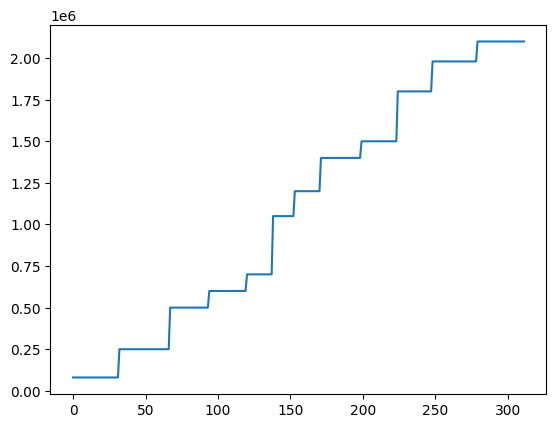

In [6]:
batch_size = 40
pivot = [80000, 250000, 500000, 600000, 700000, 1050000, 1200000, 1400000, 1500000, 1800000, 1980000, 2100000]
batches = []


for i in range(len(pivot)):
  batch_size = batch_size + random.randint(-10, 10)
  for j in range(batch_size):
    
    batches.append(pivot[i]+j)
plt.plot(batches)
plt.show()



In [7]:
[S, feat] = df.shape
#current_state = 500002
#s = current_state
#current_episode = 0
#total_episodes = 1000000

bounds = [(min_f, max_f), (0,1)]

alpha = 0.01
gamma = 1

my_batches = batches


for nn in NN:

    print("NN: ", names[NN.index(nn)])
    try:
        nn.load_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights/rete_neurale_1.h5')
        print("try")
    except:
        print("except")
        pass

    w0 = nn.get_weights()
    convergence = False

    while convergence == False:
    
        #for current_episode in range(total_episodes):
        for i in range(len(my_batches)):

            s = my_batches[i]
            s_prime = s+1
            if s_prime > S-1:
                print("s =", s)
                break
            # a1 = frequenza sul motore di mandata
            #a1 = df.loc[s,'F_M_FDBK_00']
            a1 = a_f_m_scaled[s][0]
            

            # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
            a_raf = df.loc[s,'VLV_RAF_FDBK_00']
            a_sur = df.loc[s,'VLV_SUR_FDBK_00']
            if a_raf == 0:
                if a_sur == 0:
                    a2 = 0
                else:
                    a2 = a_sur_df[s]
            else:
                a2 = a_raf_df[s]

            # r = reward 
            r = -df.loc[s,'PW_ATT_M_00']
           
            x0 = np.array([a1, a2])
            # Minimizzazione della -NN per predizione di q' per ottenere a' (a1', a2')
            print("minimizing...")
            #x0 = a.reshape(2,)
            print("x0: ", x0)
            start_time = time.time()
            objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,nn,n_components,), x0=x0, maxiter=300, tol=0.01, polish=True)
            end_time = time.time()
            print("time elapsed: ", end_time - start_time, "seconds")
            
            # Compongo input della predizione di q'
            a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
            a2_prime_input = objective_minimized.x[1].reshape(1,1)
            s_prime_input = pca_df.loc[s_prime,:].values.reshape(n_components,1)
            conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
            a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
            conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
            nn_input_prime = np.reshape(conc2, (1,input_dim))
            # Compongo input della predizione di q
            a1_input = np.array([a1]).reshape(1,1)
            a2_input = np.array([a2]).reshape(1,1)
            s_input = pca_df.loc[s,:].values.reshape(n_components,1)
            conc1 = np.concatenate((s_input, a1_input), axis=0)
            a2_input = np.expand_dims(a2_input, axis=1).reshape(1,1)
            conc2 = np.concatenate((conc1, a2_input), axis=0)
            nn_input = np.reshape(conc2, (1,input_dim))

            # Predizione di q'
            q_prime = nn.predict(nn_input_prime, verbose = 0)[0]
            q_prime = q_prime[0]

            # Predizione di q
            q_ = nn.predict(nn_input, verbose = 0)[0] 
            q_ = q_[0]

            # q = avr + gamma*max(q')
            q = q_ + alpha*(r + gamma*q_prime - q_)
            
            # Calcola il valore target per il training della rete neurale
            target = q
            target = np.array([target])

            # Aggiornamento della rete neurale
            nn.fit(nn_input, target, epochs=1, verbose=0)
            w1 = nn.get_weights()

            # Aggiornamento  dello stato corrente
            #s = s_prime

            # Plot statistiche ogni n episodi    
            n_print = 5
            if s%n_print == 0:
                print("\n")
                print("current_episode = ", s)
                #print("Episodio ",s,"/",total_episodes)
                print("q: ", q)
                print("F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
                print("VLV_RAF_FDBK_00: ", df.loc[s,'VLV_RAF_FDBK_00'])
                print("VLV_SUR_FDBK_00: ", df.loc[s,'VLV_SUR_FDBK_00'])
                print("PW_ATT_M_00: ", df.loc[s,'PW_ATT_M_00'])
                print("\n")
                if IN_COLAB == True:
                  nn.save_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights/'+names[NN.index(nn)]+'.h5')
                else:
                  string = ['/weights/DQN_',names[NN.index(nn)],'_tansig_'+str(n_components)+'input.h5']
                  string = ''.join(string)
                  nn.save_weights(string)

            # Convergenza
            if are_weights_equal(w0, w1) == True:
                #print("####### w0 \n", w0)
                #print("####### w1 \n", w1)
                convergence = True
                print("Convergenza raggiunta\n")
                if IN_COLAB == True:
                  nn.save_weights('/content/gdrive/MyDrive/Tesi_GDrive/weights/DEF'+names[NN.index(nn)]+'.h5')
                else:  
                  string = ['/weights/DEF_DQN_',names[NN.index(nn)],'_tansig_'+str(n_components)+'input.h5']
                  string = ''.join(string)
                  nn.save_weights(string)
                break

NN:  rete_neurale_1
try
minimizing...
x0:  [0.9965497 0.       ]
time elapsed:  7.0806357860565186 seconds


current_episode =  80000
q:  0.9999990463256836
F_M_FDBK_00:  99.993
VLV_RAF_FDBK_00:  0.0
VLV_SUR_FDBK_00:  0.0
PW_ATT_M_00:  0.0


Convergenza raggiunta

NN:  rete_neurale
except
minimizing...
x0:  [0.9965497 0.       ]
time elapsed:  20.069161415100098 seconds


current_episode =  80000
q:  0.3959600460529327
F_M_FDBK_00:  99.993
VLV_RAF_FDBK_00:  0.0
VLV_SUR_FDBK_00:  0.0
PW_ATT_M_00:  0.0


minimizing...
x0:  [0.99645602 0.        ]
time elapsed:  16.093778371810913 seconds
minimizing...
x0:  [0.99650187 0.        ]
time elapsed:  22.315962314605713 seconds
minimizing...
x0:  [0.99636832 0.        ]
time elapsed:  19.803409337997437 seconds
minimizing...
x0:  [0.99633244 0.        ]
time elapsed:  16.000033617019653 seconds
minimizing...
x0:  [0.99635038 0.        ]
time elapsed:  20.9964759349823 seconds


current_episode =  80005
q:  0.5129775869846344
F_M_FDBK_00:  99.97

KeyboardInterrupt: ignored

## Prova

In [ ]:
n = load_data('_.pkl')
if IN_COLAB == True:
    n = load_data('*.pkl')

action_vector_dimension = 2

# Architettura rete neurale
input_dim = n['n_components'] + action_vector_dimension
inner_dim_1 = 32
inner_dim_2 = 32
output_dim = 1

print("input dim: ", input_dim)
print("inner layer1 dim: ", inner_dim_1)
print("inner layer2 dim: ", inner_dim_2)
print("output dim: ", output_dim)

# Definizione rete neurale
rete_neurale = Sequential()
rete_neurale.add(Dense(inner_dim_1, input_dim=input_dim, activation='relu'))
rete_neurale.add(Dense(inner_dim_2, input_dim=inner_dim_1, activation='relu'))
rete_neurale.add(Dense(output_dim, input_dim=inner_dim_2, activation='relu'))

adam = Adam(learning_rate=0.001)
rete_neurale.compile(loss='mse', optimizer=adam, metrics=['mae'])

rete_neurale.load_weights('DEFrete_neurale_DQN_32321_relu.h5')

# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x, s_prime):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(n_components,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

def are_weights_equal(w0, w1):
    # Verifica se le due liste hanno la stessa lunghezza
    if len(w0) != len(w1):
        return False
    
    # Verifica se gli elementi delle due liste sono uguali
    for i in range(len(w0)):
        if isinstance(w0[i], list) and isinstance(w1[i], list):
            # Se l'elemento corrente è una lista, richiama la funzione in modo ricorsivo
            if not are_weights_equal(w0[i], w1[i]):
                return False
        else:
            # Altrimenti, verifica se gli array NumPy sono uguali
            if not np.array_equal(w0[i], w1[i]):
                return False
    
    # Se tutte le verifiche precedenti sono state superate, le due liste sono uguali
    return True



In [ ]:
[S, feat] = df.shape
current_state = 7328
s = current_state
current_episode = 0
total_episodes = 10000

bounds = [(min_f, max_f), (0,1)]

alpha = 0.5
gamma = 1

convergence = False
w0 = rete_neurale.get_weights()

while convergence == False:
  
  for current_episode in range(total_episodes):

      s_prime = s+1
      if s_prime > S-1:
        print("s =", s)
        break
      # a1 = frequenza sul motore di mandata
      a1 = df.loc[s,'F_M_FDBK_00']

      # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
      a_raf = df.loc[s,'VLV_RAF_REG_00']
      a_sur = df.loc[s,'VLV_SUR_REG_00']
      if a_raf == 0:
        if a_sur == 0:
          a2 = 0
        else:
          a2 = a_sur_df[s]
      else:
        a2 = a_raf_df[s]
        
      a = (a1,a2)

      # r = reward 
      r = -df.loc[s,'PW_ATT_M_00']

      # Condizioni iniziali random per la minimizzazione
      #data_f = a_f_m_scaled
      #a0_f = data_f[np.random.randint(len(data_f))]
      #a0_v = np.random.rand()
      #x0 = [a0_f, a0_v]
    
      # Dominio della minimizzazione 
      print("minimizing...")
      start_time = time.time()
      # Risultato della minimizzazione
      objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,))
      end_time = time.time()
      print("time elapsed: ", end_time - start_time, "seconds")
    
      # Compongo input della predizione di q'
      a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
      a2_prime_input = objective_minimized.x[1].reshape(1,1)
      s_prime_input = pca_df.loc[s_prime,:].values.reshape(n_components,1)
      conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
      a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
      nn_input_prime = np.reshape(conc2, (1,input_dim))
      # Compongo input della predizione di q
      a1_input = np.array([a1]).reshape(1,1)
      a2_input = np.array([a2]).reshape(1,1)
      s_input = pca_df.loc[s,:].values.reshape(n_components,1)
      conc1 = np.concatenate((s_input, a1_input), axis=0)
      a2_input = np.expand_dims(a2_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_input), axis=0)
      nn_input = np.reshape(conc2, (1,input_dim))

      # Predizione di q'
      q_prime = rete_neurale.predict(nn_input_prime, verbose = 0)[0]
      q_prime = q_prime[0]

      # Predizione di q
      q_ = rete_neurale.predict(nn_input, verbose = 0)[0] 
      q_ = q_[0]

      # q = avr + gamma*max(q')
      q = q_ + alpha*(r + gamma*q_prime - q_)
      
      #print("F_M_FDBK_00: ", df.iloc[s,'F_M_FDBK_00'])
      # Calcola il valore target per il training della rete neurale
      target = q
      target = np.array([target])

      # Aggiornamento della rete neurale
      rete_neurale.fit(nn_input, target, epochs=1, verbose=0)
      w1 = rete_neurale.get_weights()

      # Aggiornamento  dello stato corrente
      s = s_prime

      # Plot statistiche ogni n episodi    
      n_print = 5
      if current_episode%n_print == 0:
        print("\n")
        print("current_episode = ", current_episode)
        print("Episodio ",current_episode,"/",total_episodes)
        print("q: ", q)
        print("F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
        print("VLV_RAF_FDBK_00: ", df.loc[s,'VLV_RAF_REG_00'])
        print("VLV_SUR_FDBK_00: ", df.loc[s,'VLV_SUR_REG_00'])
        print("\n")
        rete_neurale.save_weights('rete_neurale_DQN_32321_relu.h5')

      # Convergenza
      if are_weights_equal(w0, w1) == True:
        convergence = True
        print("Convergenza raggiunta")
        rete_neurale.save_weights('DEFrete_neurale_DQN_32321_relu.h5')
        break



 




In [ ]:
objective_minimized = differential_evolution(objective, bounds=bounds)

In [ ]:
objective_minimized.x

In [ ]:
print("a1: ", objective_minimized.x[0])
print("a2: ", objective_minimized.x[1])

In [ ]:
s_random = [0, 25, 2984, 459000, 657, 372122, 600000]
s_random = sorted(s_random)
my_list = []

for s in s_random:
    objective_minimized = differential_evolution(objective, bounds=bounds, args=(s,))
    a1 = np.array([objective_minimized.x[0]]).reshape(1,1)
    a2 = np.array([objective_minimized.x[1]]).reshape(1,1)
    pca_s = pca_df.loc[s,:]
    nn_input = np.concatenate((pca_s.values.reshape(7,1), a1, a2), axis=0)
    nn_input = np.reshape(nn_input, (1,input_dim))
    funct = rete_neurale.predict(nn_input, verbose=0)[0][0]

    dict = {'s': s, 'a1': a1, 'a2': a2, 'funct': funct}
    my_list.append(dict)
    
    print("s: ", s)
    print("a1: ", a1)
    print("a2: ", a2)
    print("funct: ", funct)
    print("\n")


In [ ]:
print("a1: ", objective_minimized.x[0])
print("a2: ", objective_minimized.x[1])

In [ ]:
n = load_data('_.pkl')
if IN_COLAB == True:
    n = load_data('*.pkl')

action_vector_dimension = 2

# Architettura rete neurale
input_dim = n['n_components'] + action_vector_dimension
inner_dim_1 = 64
inner_dim_2 = 64
output_dim = 1

print("input dim: ", input_dim)
print("inner layer1 dim: ", inner_dim_1)
print("inner layer2 dim: ", inner_dim_2)
print("output dim: ", output_dim)

# Definizione rete neurale
rete_neurale_1 = Sequential()
rete_neurale_1.add(Dense(inner_dim_1, input_dim=input_dim, activation='relu'))
rete_neurale_1.add(Dense(inner_dim_2, input_dim=inner_dim_1, activation='relu'))
rete_neurale_1.add(Dense(output_dim, input_dim=inner_dim_2, activation='relu'))

adam = Adam(learning_rate=0.001)
rete_neurale_1.compile(loss='mse', optimizer=adam, metrics=['mae'])

rete_neurale_1.load_weights('rete_neurale_DQN_64641_relu.h5')

# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x, s_prime):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(7,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale_1.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

def are_weights_equal(w0, w1):
    # Verifica se le due liste hanno la stessa lunghezza
    if len(w0) != len(w1):
        return False
    
    # Verifica se gli elementi delle due liste sono uguali
    for i in range(len(w0)):
        if isinstance(w0[i], list) and isinstance(w1[i], list):
            # Se l'elemento corrente è una lista, richiama la funzione in modo ricorsivo
            if not are_weights_equal(w0[i], w1[i]):
                return False
        else:
            # Altrimenti, verifica se gli array NumPy sono uguali
            if not np.array_equal(w0[i], w1[i]):
                return False
    
    # Se tutte le verifiche precedenti sono state superate, le due liste sono uguali
    return True



In [ ]:
[S, feat] = df.shape
current_state = 7328
s = current_state
current_episode = 0
total_episodes = 10000

bounds = [(min_f, max_f), (0,1)]

alpha = 0.5
gamma = 1

convergence = False
w0 = rete_neurale_1.get_weights()

while convergence == False:
  
  for current_episode in range(total_episodes):

      s_prime = s+1
      if s_prime > S-1:
        print("s =", s)
        break
      # a1 = frequenza sul motore di mandata
      a1 = df.loc[s,'F_M_FDBK_00']

      # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
      a_raf = df.loc[s,'VLV_RAF_FDBK_00']
      a_sur = df.loc[s,'VLV_SUR_FDBK_00']
      if a_raf == 0:
        if a_sur == 0:
          a2 = 0
        else:
          a2 = a_sur_df[s]
      else:
        a2 = a_raf_df[s]
        
      a = (a1,a2)

      # r = reward 
      r = -df.loc[s,'PW_ATT_M_00']

      # Condizioni iniziali random per la minimizzazione
      #data_f = a_f_m_scaled
      #a0_f = data_f[np.random.randint(len(data_f))]
      #a0_v = np.random.rand()
      #x0 = [a0_f, a0_v]
    
      # Dominio della minimizzazione 
      print("minimizing...")
      start_time = time.time()
      # Risultato della minimizzazione
      objective_minimized = differential_evolution(objective, bounds=bounds, args=(s_prime,))
      end_time = time.time()
      print("time elapsed: ", end_time - start_time, "seconds")
    
      # Compongo input della predizione di q'
      a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
      a2_prime_input = objective_minimized.x[1].reshape(1,1)
      s_prime_input = pca_df.loc[s_prime,:].values.reshape(7,1)
      conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
      a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
      nn_input_prime = np.reshape(conc2, (1,input_dim))
      # Compongo input della predizione di q
      a1_input = np.array([a1]).reshape(1,1)
      a2_input = np.array([a2]).reshape(1,1)
      s_input = pca_df.loc[s,:].values.reshape(7,1)
      conc1 = np.concatenate((s_input, a1_input), axis=0)
      a2_input = np.expand_dims(a2_input, axis=1).reshape(1,1)
      conc2 = np.concatenate((conc1, a2_input), axis=0)
      nn_input = np.reshape(conc2, (1,input_dim))

      # Predizione di q'
      q_prime = rete_neurale_1.predict(nn_input_prime, verbose = 0)[0]
      q_prime = q_prime[0]

      # Predizione di q
      q_ = rete_neurale_1.predict(nn_input, verbose = 0)[0] 
      q_ = q_[0]

      # q = avr + gamma*max(q')
      q = q_ + alpha*(r + gamma*q_prime - q_)
      
      #print("F_M_FDBK_00: ", df.iloc[s,'F_M_FDBK_00'])
      # Calcola il valore target per il training della rete neurale
      target = q
      target = np.array([target])

      # Aggiornamento della rete neurale
      rete_neurale_1.fit(nn_input, target, epochs=1, verbose=0)
      w1 = rete_neurale_1.get_weights()

      # Aggiornamento  dello stato corrente
      s = s_prime

      # Plot statistiche ogni n episodi    
      n_print = 5
      if current_episode%n_print == 0:
        print("\n")
        print("current_episode = ", current_episode)
        print("Episodio ",current_episode,"/",total_episodes)
        print("q: ", q)
        print("F_M_FDBK_00: ", df.loc[s,'F_M_FDBK_00'])
        print("VLV_RAF_FDBK_00: ", df.loc[s,'VLV_RAF_FDBK_00'])
        print("VLV_SUR_FDBK_00: ", df.loc[s,'VLV_SUR_FDBK_00'])
        print("\n")
        rete_neurale_1.save_weights('rete_neurale_DQN_64641_relu.h5')

      # Convergenza
      if are_weights_equal(w0, w1) == True:
        convergence = True
        print("Convergenza raggiunta")
        rete_neurale_1.save_weights('DEFrete_neurale_DQN_64641_relu.h5')
        break



 


